# **Price Study Notebook**

## Objectives

* Answer business requirement 1:
- The client is interested in identifying key variables that correlate with significant Bitcoin price changes.

## Inputs

* outputs/datasets/collection/BTCDaily.csv

## Outputs

* generate code that answers business requirement 1 and can be used to build the Streamlit App  

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/bitcoin-forecast/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/bitcoin-forecast'

# Load Data

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/BTCDaily.csv"))
df.head()

,date,open,high,low,close,Volume BTC,Volume USD
0,2014-11-28,363.59,381.34,360.57,376.28,3220878.18,8617.15
1,2014-11-29,376.42,386.60,372.25,376.72,2746157.05,7245.19
2,2014-11-30,376.57,381.99,373.32,373.34,1145566.61,3046.33
3,2014-12-01,376.40,382.31,373.03,378.39,2520662.37,6660.56
4,2014-12-02,378.39,382.86,375.23,379.25,2593576.46,6832.53


---

# Data Exploration

We want to become more familiar with the dataset by examining variable types and distributions, identifying missing values, and understanding the business context of these variables.

In [5]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

***Observations and Conclusions:***
The analysis of the dataset revealed that there are no missing values, indicating a complete record of daily prices. However, the date variable is currently stored in text format, which is not ideal for time series analysis.

- Next Steps:
1. Convert the 'date' variable to datetime format.

In [6]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        2651 non-null   datetime64[ns]
 1   open        2651 non-null   float64       
 2   high        2651 non-null   float64       
 3   low         2651 non-null   float64       
 4   close       2651 non-null   float64       
 5   Volume BTC  2651 non-null   float64       
 6   Volume USD  2651 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 145.1 KB


2. Set the 'date' as the index of the DataFrame.

In [7]:
df.set_index('date', inplace=True)
df.head()

,open,high,low,close,Volume BTC,Volume USD
date,,,,,,
2014-11-28,363.59,381.34,360.57,376.28,3220878.18,8617.15
2014-11-29,376.42,386.60,372.25,376.72,2746157.05,7245.19
2014-11-30,376.57,381.99,373.32,373.34,1145566.61,3046.33
2014-12-01,376.40,382.31,373.03,378.39,2520662.37,6660.56
2014-12-02,378.39,382.86,375.23,379.25,2593576.46,6832.53


3. Verify the integrity of the index and explore for any potential missing days in the dataset.
It is noted that there are no missing dates.

In [8]:
#Source: https://pandas.pydata.org/docs/reference/api/pandas.date_range.html
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
missing_days = full_date_range[~full_date_range.isin(df.index)]  # Identifies dates in `full_date_range` that are not in the DataFrame index, indicating missing days.
print(missing_days)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')


# Correlation Study

Here the correlation between all quantities is visualized.

In [9]:
df.corr()

,open,high,low,close,Volume BTC,Volume USD
open,1.000000,0.999485,0.998983,0.998798,-0.048598,0.609992
high,0.999485,1.000000,0.998901,0.999474,-0.045371,0.617662
low,0.998983,0.998901,1.000000,0.999319,-0.056040,0.593531
close,0.998798,0.999474,0.999319,1.000000,-0.049489,0.608673
Volume BTC,-0.048598,-0.045371,-0.056040,-0.049489,1.000000,-0.160242
Volume USD,0.609992,0.617662,0.593531,0.608673,-0.160242,1.000000


- There is a very strong positive correlation among the daily price variables
- The volume in USD has a moderate positive correlation with price metrics, while volume in BTC has a weak correlation

We use .corr() for spearman and pearson methods, and investigate the top correlations

In [10]:
corr_spearman = df.corr(method='spearman')['close']
print("\nSpearman Correlation with Closing Price:")
print(corr_spearman)


Spearman Correlation with Closing Price:
open          0.999043
high          0.999490
low           0.999513
close         1.000000
Volume BTC   -0.611318
Volume USD    0.806241
Name: close, dtype: float64


In [11]:
corr_pearson = df.corr(method='pearson')['close']
print("Pearson Correlation with Closing Price:")
print(corr_pearson)

Pearson Correlation with Closing Price:
open          0.998798
high          0.999474
low           0.999319
close         1.000000
Volume BTC   -0.049489
Volume USD    0.608673
Name: close, dtype: float64


- The Spearman correlation reveals a strong positive relationship between USD volume and closing prices (0.81), while BTC volume shows a moderate negative correlation.  
- The Pearson correlation indicates a moderate positive relationship between USD volume and closing prices (0.61), confirming that higher USD volumes are likely associated with higher closing prices.

# EDA on studied variables

We create a line plot to observe how the closing price relates to the high and low ranges during a bear market and a bull market.

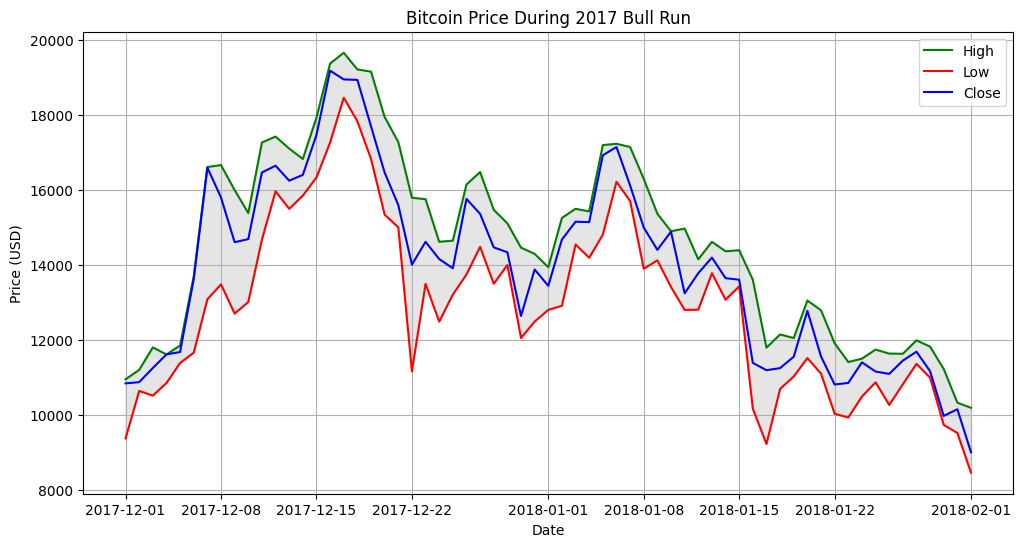

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the dataset for the specified date range
start_date = '2017-12-01'
end_date = '2018-02-01'
df_bull_run = df[(df.index >= start_date) & (df.index <= end_date)]

# Plot the filtered data
plt.figure(figsize=(12, 6))
plt.plot(df_bull_run.index, df_bull_run['high'], label='High', color='green')
plt.plot(df_bull_run.index, df_bull_run['low'], label='Low', color='red')
plt.plot(df_bull_run.index, df_bull_run['close'], label='Close', color='blue')
plt.fill_between(df_bull_run.index, df_bull_run['low'], df_bull_run['high'], color='grey', alpha=0.2)
plt.title('Bitcoin Price During 2017 Bull Run')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

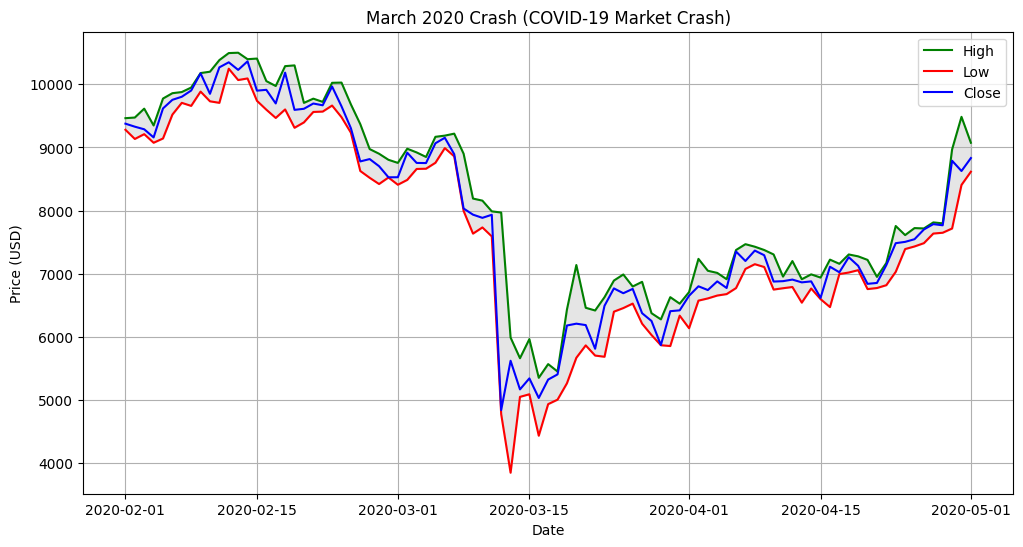

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the dataset for the specified date range
start_date = '2020-02-01'
end_date = '2020-05-01'
df_crash = df[(df.index >= start_date) & (df.index <= end_date)]

# Plot the filtered data
plt.figure(figsize=(12, 6))
plt.plot(df_crash.index, df_crash['high'], label='High', color='green')
plt.plot(df_crash.index, df_crash['low'], label='Low', color='red')
plt.plot(df_crash.index, df_crash['close'], label='Close', color='blue')
plt.fill_between(df_crash.index, df_crash['low'], df_crash['high'], color='grey', alpha=0.2)
plt.title('March 2020 Crash (COVID-19 Market Crash)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

We create an overlay plot to analyze the relationship between Bitcoin's closing price and trading volume, with green bars representing positive volume and red bars indicating negative volume. 

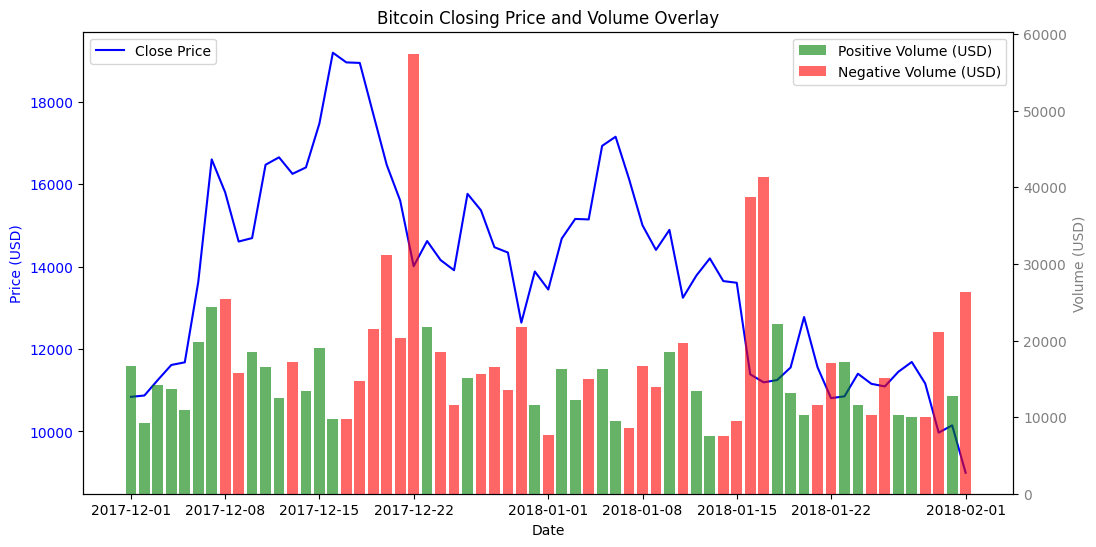

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the DataFrame for the desired date range
start_date = '2017-12-01'
end_date = '2018-02-01'
df_filtered = df[(df.index >= start_date) & (df.index <= end_date)]

# Create a figure with two axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot closing price on the first axis
ax1.plot(df_filtered.index, df_filtered['close'], label='Close Price', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Bitcoin Closing Price and Volume Overlay')

# Create a second y-axis to plot volume
ax2 = ax1.twinx()

# Determine positive and negative volume
positive_volume = df_filtered['Volume USD'][df_filtered['close'] > df_filtered['open']]
negative_volume = df_filtered['Volume USD'][df_filtered['close'] <= df_filtered['open']]

# Plot positive volume in green and negative volume in red
ax2.bar(df_filtered.index[df_filtered['close'] > df_filtered['open']], 
        positive_volume, alpha=0.6, color='green', label='Positive Volume (USD)')

ax2.bar(df_filtered.index[df_filtered['close'] <= df_filtered['open']], 
        negative_volume, alpha=0.6, color='red', label='Negative Volume (USD)')

ax2.set_ylabel('Volume (USD)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

# Conclusions and Next Steps

The analysis of Bitcoin price movements reveals distinct patterns across market conditions.

- In a bull market, the closing price aligns closely with the high price.
- During a market crash, the closing price is more correlated with the low price.
- The overlay plot indicates that positive volume correlates with price increases, while negative volume aligns with price decreases.

Next steps may include further investigations into the specific factors driving these correlations and exploring additional features that could enhance predictive modeling.